In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import copy
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from collections import defaultdict

In [2]:
np.__version__

'1.19.5'

In [3]:
bkdatafolder = "/Volumes/T7 Touch/TheseProject/DR_KELLA/BKDataCleaned/"
dataset_name = os.listdir(bkdatafolder)

In [4]:
def createDictFloor(floor_name):
    getdict = {}
    floors = [floor for floor in dataset_name if floor_name in floor]
    for name in floors:
        floorname = name.split(".")[0]
        getdict[floorname] = pd.read_csv(bkdatafolder+name, index_col=0, parse_dates=["Date"])
        getdict[floorname] = getdict[floorname].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def createPlot(date1, date2, features, data):
    for floor in data.keys():
        data[floor].resample("5T").mean()[features][date1:date2].plot(figsize=(20,7))
        

def createDTFeat(date1, date2, datadict, features, resample_method="sum" ,scale=True):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for data in datadict.keys():
        if resample_method == "sum":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").sum()
            
        elif resample_method == "max":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").max().bfill()
        elif resample_method == "mean":
            resample_move[data] = floor_dict[data][date1:date2].resample(
                "5min").mean().bfill()
            
        cols = resample_move[data].columns
        idx = resample_move[data].index

        if scale:
            scaler = MinMaxScaler()
            scaler.fit(resample_move[data])
            resample_move[data] = pd.DataFrame(scaler.transform(
                resample_move[data]),
                                               columns=cols,
                                               index=idx)
            scalers[data] = scaler

        resample_move[data]["weekday"] = resample_move[data].index.day_name()
        resample_move[data]["date"] = resample_move[data].index.date
        resample_move[data]["time"] = resample_move[data].index.time

        nan = np.where(pd.isnull(resample_move[data][features]))[0]
        index_nan[data] = np.unique(resample_move[data].iloc[nan]["time"])

    return resample_move, scalers, index_nan

def getInfoTimeShape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [5]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            databyDate[date][floor] = np.asarray(datadict[floor][date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))

In [6]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor_dict = createDictFloor("Floor7")
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698



In [7]:
featureX = "temperature"
resampleX_method = "max"
resampleX, scalersX, index_nan = createDTFeat(date1, date2, floor_dict, featureX,resample_method=resampleX_method)
cleanedDataX, remain_date = cleanNan(resampleX, index_nan)

In [237]:
cutting_date1 = "2019-08-08"
cutting_date2 = "2019-09-08"
myfloor = "Floor7Z1"

lookback = 13
lookahead = 5
batch_size = 16
train_date, test_date = splitDate(remain_date, cutting_date1)
valid_date, test_date = splitDate(test_date, cutting_date2)
databyDateX = createDataByDate(cleanedDataX, featureX, remain_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_5587/2632087007.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [238]:
traindata = np.asarray([databyDateX[date][myfloor] for date in train_date]).flatten()
validdata = np.asarray([databyDateX[date][myfloor] for date in valid_date]).flatten()
testdata = np.asarray([databyDateX[date][myfloor] for date in test_date]).flatten()

In [239]:
xtrain, ytrain= to_timeseries_input(traindata,lookback=lookback, predictions=lookahead)
xval, yval = to_timeseries_input(validdata,lookback=lookback, predictions=lookahead)
xtest, ytest = to_timeseries_input(testdata, lookback=lookback, predictions=lookahead)

xtrain = np.expand_dims(xtrain, axis=-1)
xval = np.expand_dims(xval, axis=-1)
xtest = np.expand_dims(xtest,axis=-1)

In [243]:
inputs = Input(shape=(lookback, 1))
lstm_out = keras.layers.LSTM(10, return_sequences=False)(inputs)
outputs = keras.layers.Dense(5)(lstm_out)

model = keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss="mae")
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 13, 1)]           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 55        
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________


In [244]:
#path_ckpts = "./kerascheckpts/"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

In [245]:
history = model.fit(xtrain, ytrain, batch_size = 16, epochs=100,
                    validation_data=(xval, yval),
                   callbacks=[es_callback])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2766/2789 [============================>.] - ETA: 0s - loss: 0.0353WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b0e2ab80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2789/2789 [==============================] - 4s 1ms/step - loss: 0.0352 - val_loss: 0.0155
Epoch 2/100
2789/2789 [==============================] - 3s 1ms/step - loss: 0.0175 - val_loss: 0.0155
Epoch 3/100
2789/2789 [==============================] - 3s 1ms/step - loss: 0.0173 - val_loss: 0.0187
Epoch 4/100
2789/2789 [==============================] - 3s 1ms/step - loss: 0.0171 - val_loss: 0.0151
Epoch 5/100
2789/2789 [==============================] - 3s 1ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 6/100
2789/2789 [==============================] - 3s 1ms/step - loss: 0.0166 - val_loss: 0.0165
Epoch 7/100
2789/2789 [==============================] - 3s 1ms/step - loss: 

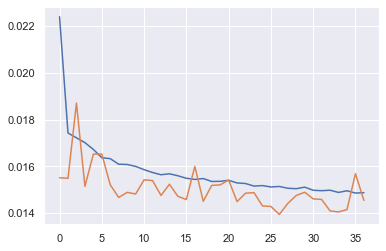

In [246]:
loss = history.history["loss"]
valloss = history.history["val_loss"]

plt.plot(loss)
plt.plot(valloss)

In [249]:
pred0 = model.predict(xtest[::lookback][0:50]).flatten()
y0 = ytest[::lookback][0:50].flatten()

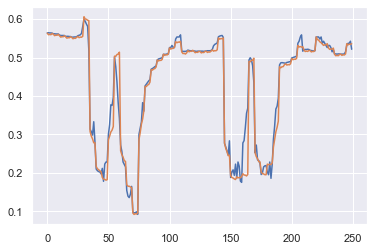

In [250]:
plt.plot(y0)
plt.plot(pred0)

In [262]:
inputs = Input(batch_shape=(1,lookback,1))
lstm_out = keras.layers.LSTM(10, return_sequences=False, stateful=True)(inputs)
outputs = keras.layers.Dense(5)(lstm_out)

model1 = keras.Model(inputs = inputs, outputs = outputs)
model1.compile(optimizer=Adam(learning_rate=0.01), loss="mae")
model1.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(1, 13, 1)]              0         
_________________________________________________________________
lstm_45 (LSTM)               (1, 10)                   480       
_________________________________________________________________
dense_33 (Dense)             (1, 5)                    55        
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________


In [263]:
model1.set_weights(model.get_weights())

In [264]:
model1.reset_states()

In [266]:
setstate = model1.predict(xval[0:1])

In [269]:
init = xtest[0:1]
laststep = xtest[0:1]
for i in range(1,50+1):
    sample = model1.predict(laststep)
    init = tf.concat((init, tf.expand_dims(sample,axis=-1)),axis=1)
    laststep = init[:,-lookback,:]
model1.reset_states()

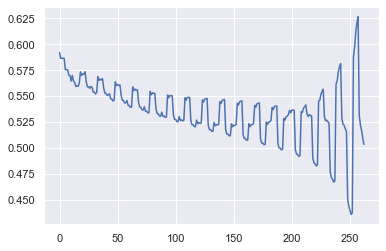

In [270]:
plt.plot(np.asarray(init).flatten()[:])